### This for the Double Integrator

In [1]:
import copy
import cupy as cp
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

import sys
from os.path import abspath, join
sys.path.append(abspath(join('..')))
from BRATVisualization.rcbrt_visu import RCBRTVisualizer
sys.path.append(abspath(join('../..')))
from LevelSetPy.Utilities import *
from LevelSetPy.Grids import createGrid
from LevelSetPy.Helper import postTimeStepTTR
from LevelSetPy.Visualization import implicit_mesh
from LevelSetPy.DynamicalSystems import DoubleIntegrator
from LevelSetPy.SpatialDerivative import upwindFirstENO2
from LevelSetPy.ExplicitIntegration import artificialDissipationGLF
from LevelSetPy.ExplicitIntegration.Integration import odeCFL2, odeCFLset
from LevelSetPy.ExplicitIntegration.Term import termRestrictUpdate, termLaxFriedrichs

In [2]:
gmin = np.array(([[-1, -1]]),dtype=np.float64).T
gmax = np.array(([[1, 1]]),dtype=np.float64).T
g = createGrid(gmin, gmax, 101, None)

eps_targ = 1.0
u_bound = 1
target_rad = .2 #eps_targ * np.max(g.dx)
dint = DoubleIntegrator(g, u_bound)
attr = dint.mttr() - target_rad

value_func = copy.copy(attr)
value_func_init = copy.copy(value_func)

attr = np.maximum(0, attr)

args = Bundle(dict(elevation=5, azimuth=5, pause_time=1,visualize=False))
#turn the state space over to the gpu
g.xs = [cp.asarray(x) for x in g.xs]
finite_diff_data = Bundle({'grid':g, 'hamFunc': dint.hamiltonian,
				'partialFunc': dint.dynamics,
				'dissFunc': artificialDissipationGLF,
				'derivFunc': upwindFirstENO2,
				'input_bound': u_bound,
				'innerFunc': termLaxFriedrichs,
				'positive': False,  # direction to grow the updated level set
				})
innerData =  copy.copy(finite_diff_data)
del finite_diff_data

# # Wrap the true Hamiltonian inside the term approximation restriction routine.
finite_diff_data = Bundle(dict(innerFunc = termLaxFriedrichs,
								innerData = innerData,
								positive = False,  # direction to grow the updated level set
							))
small = 100*eps
t_span = np.linspace(0, 2.0, 20)
options = Bundle(dict(factorCFL=0.75, stats='on', maxStep=realmax, \
						singleStep='off', postTimestep=postTimeStepTTR))

y = copy.copy(value_func.flatten())
y, finite_diff_data = postTimeStepTTR(0, y, finite_diff_data)
value_func = cp.asarray(copy.copy(y.reshape(g.shape)))

# Visualization paramters
spacing = tuple(g.dx.flatten().tolist())
params = Bundle(
				{"grid": g,
					'disp': True,
					'labelsize': 16,
					'labels': "Initial 0-LevelSet",
					'linewidth': 2,
					'data': value_func,
					'elevation': args.elevation,
					'azimuth': args.azimuth,
					'mesh': value_func.get(),
					'init_conditions': False,
					'pause_time': args.pause_time,
					'level': 0, # which level set to visualize
					'winsize': (16,9),
					'fontdict': Bundle({'fontsize':12, 'fontweight':'bold'}),
					"savedict": Bundle({"save": False,
								"savename": "rcbrt",
								"savepath": "../jpeg_dumps/rcbrt"})
					})

if args.visualize:
	viz = RCBRTVisualizer(params)

value_func_all = [value_func]

cur_time, max_time = 0, t_span[-1]
step_time = (t_span[-1]-t_span[0])/8.0

start_time = cputime()
itr_start = cp.cuda.Event()
itr_end = cp.cuda.Event()

# project the state spaces (dim-by-dim) unto reduced basis

To project in an informed manner, we choose an approximation error
    $\epsilon$ e.g. 1e-5. 

We can construct a POD basis $V_r$ to use in the construction of the ROM.
There are a few ways to make an informed choice of $r$; in this example, we examine the _projection error_, defined by
$$
\text{err}_\text{projection} = \frac{||X - V_rV_r^\mathsf{T}X||_F}{||X||_F}.
$$
We choose $r$ so that the projection error is under $10^{-5}$.



In [19]:
value_func.shape

(101, 101)

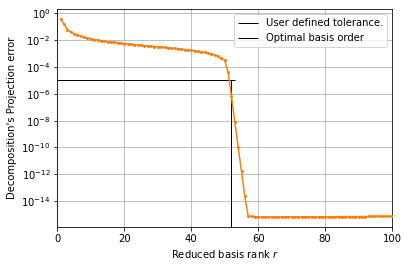

In [26]:
from LevelSetPy.POD import *
# Calculate the projection errors.
VFunc = value_func.get()
V, svdvals = pod_basis(VFunc, max(VFunc.shape))
min_rank = minimal_projection_error(VFunc, V, eps=1e-5, plot=True)

In [27]:
# optimal basis rank is 52
Vr = V[:,:min_rank]
projection_error(VFunc, Vr)

6.305593432747569e-07

Now we have the value funtion, and state space in this reduced basis 
which suposedly has the most energetic state for the system.
Try using the levelsets toolbox to resolve this. First visualize the most energetic state in this reduced basis function.

g_rom = copy.deepcopy(g)

In [75]:
g_rom = copy.deepcopy(g)

#Project the state space to this reduced basis
g_rom.xs[0] = g.xs[0].get() @ Vr
g_rom.xs[1] = g.xs[1].get() @ Vr

# Project original value function onto this reduced basis too
V_rom = value_func.get()@Vr
g_rom.N = min_rank 
g_rom.shape = g_rom.xs[0].shape
g_rom.dx  = [np.zeros_like(g_rom.xs[0]), \
             np.zeros_like(g_rom.xs[1])]
g_rom.dx[0] = np.diff(g_rom.xs[0], prepend=g_rom.xs[0][0,-1]-g_rom.xs[0][1,-1]) 
g_rom.dx[1] = np.diff(g_rom.xs[1], prepend=g_rom.xs[1][0,-1]-g_rom.xs[1][1,-1])            

In [ ]:
while max_time-cur_time > small * max_time:
	itr_start.record()
	cpu_start = cputime()

	time_step = f"{cur_time:.2f}/{max_time:.2f}"

	y0 = value_func.flatten()

	#How far to integrate
	t_span = np.hstack([cur_time, min(max_time, cur_time + step_time)])

	# one step of integration
	t, y, finite_diff_data = odeCFL2(termRestrictUpdate, t_span, y0, options, finite_diff_data)
	cp.cuda.Stream.null.synchronize()
	cur_time = t if np.isscalar(t) else t[-1]

	value_func = cp.reshape(y, g.shape)

	if args.visualize:
		data_np = value_func.get()
		mesh=implicit_mesh(data_np, level=0, spacing=spacing,
							edge_color='None',  face_color='red')
		viz.update_tube(data_np, mesh, args.pause_time)
	
	itr_end.record()
	itr_end.synchronize()
	cpu_end = cputime()
	
	info(f't: {time_step} | GPU time: {(cp.cuda.get_elapsed_time(itr_start, itr_end)):.2f} | CPU Time: {(cpu_end-cpu_start):.2f}, | Targ bnds {min(y):.2f}/{max(y):.2f} Norm: {np.linalg.norm(y, 2):.2f}')
	
	# store this brt
	value_func_all.append(value_func.get())
		
	end_time = cputime()
	info(f'Total BRS/BRT execution time {(end_time - start_time):.4f} seconds.')